In [1]:
import jcopdl, luwiji

In [2]:
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

In [3]:
from luwiji.rnn import illustration

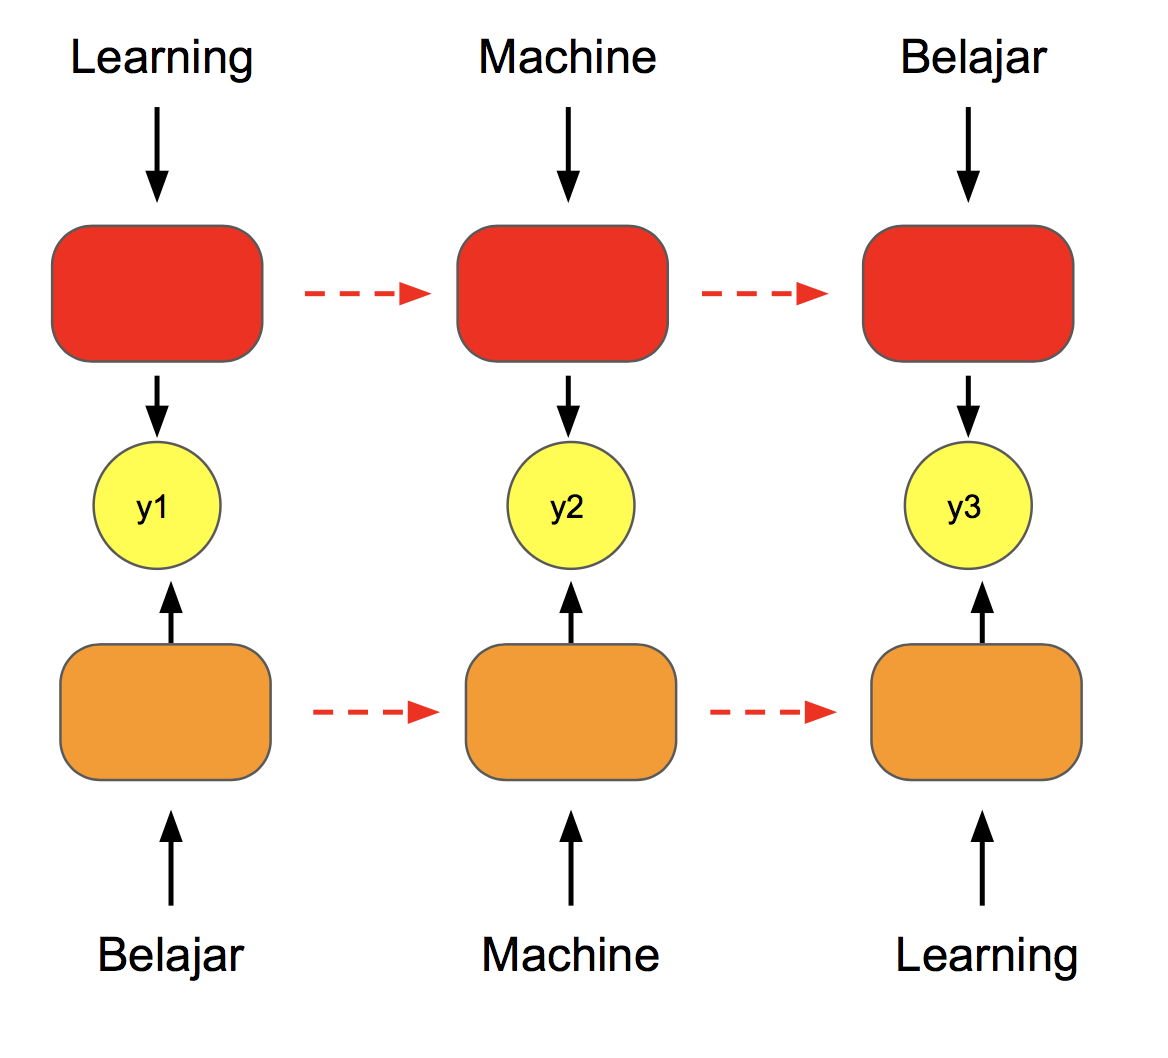

In [4]:
illustration.blstm

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [6]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [7]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


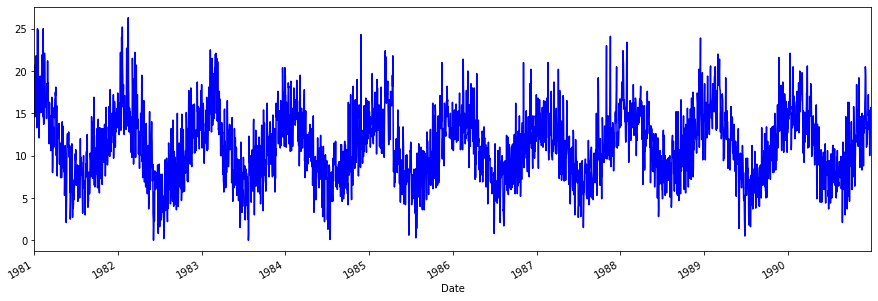

In [8]:
df.Temp.plot(figsize=(15, 5), color ="b")

# Dataset Splitting

In [9]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [10]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [11]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [12]:
class BLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

In [13]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [14]:
model = BLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/bilstm")

# Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset,dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode =="test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 129.6458 | Test_cost  = 121.6094 | 




Epoch     2
Train_cost  = 101.3296 | Test_cost  = 87.4071 | 




Epoch     3
Train_cost  = 69.5033 | Test_cost  = 58.1765 | 




Epoch     4
Train_cost  = 45.1017 | Test_cost  = 38.0357 | 




Epoch     5
Train_cost  = 29.8928 | Test_cost  = 26.7606 | 




Epoch     6
Train_cost  = 22.1125 | Test_cost  = 21.1763 | 




Epoch     7
Train_cost  = 18.5578 | Test_cost  = 18.5750 | 




Epoch     8
Train_cost  = 17.1765 | Test_cost  = 17.5597 | 




Epoch     9
Train_cost  = 16.7981 | Test_cost  = 17.2310 | 




Epoch    10
Train_cost  = 16.7468 | Test_cost  = 17.1386 | 




Epoch    11
Train_cost  = 16.7401 | Test_cost  = 17.1146 | 




Epoch    12
Train_cost  = 16.7123 | Test_cost  = 17.1139 | 




Epoch    13
Train_cost  = 16.6725 | Test_cost  = 17.1251 | 
==> EarlyStop patience =  1 | Best test_cost: 17.1139




Epoch    14
Train_cost  = 16.6362 | Test_cost  = 17.1397 | 
==> EarlyStop patience =  2 | Best test_cost: 17.1139




Epoch    15
Train_cost  = 16.6094 | Test_cost  = 17.1455 | 
==> EarlyStop patience =  3 | Best test_cost: 17.1139




Epoch    16
Train_cost  = 16.5778 | Test_cost  = 17.0922 | 




Epoch    17
Train_cost  = 16.4584 | Test_cost  = 16.9965 | 




Epoch    18
Train_cost  = 16.3721 | Test_cost  = 16.8273 | 




Epoch    19
Train_cost  = 16.2316 | Test_cost  = 16.6695 | 




Epoch    20
Train_cost  = 16.0905 | Test_cost  = 16.4789 | 


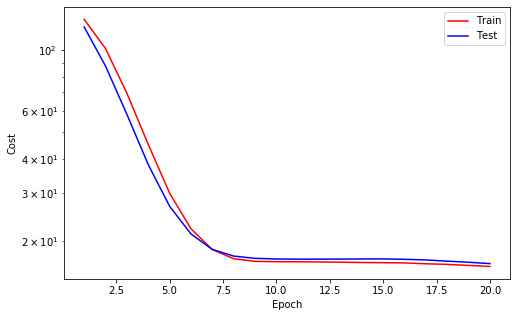



Epoch    21
Train_cost  = 15.9117 | Test_cost  = 16.2588 | 




Epoch    22
Train_cost  = 15.6989 | Test_cost  = 16.0062 | 




Epoch    23
Train_cost  = 15.4096 | Test_cost  = 15.6566 | 




Epoch    24
Train_cost  = 14.9781 | Test_cost  = 15.0695 | 




Epoch    25
Train_cost  = 14.1949 | Test_cost  = 13.8992 | 




Epoch    26
Train_cost  = 12.7307 | Test_cost  = 12.1162 | 




Epoch    27
Train_cost  = 11.0780 | Test_cost  = 10.2664 | 




Epoch    28
Train_cost  = 9.4999 | Test_cost  = 8.8590 | 




Epoch    29
Train_cost  = 8.4327 | Test_cost  = 7.8798 | 




Epoch    30
Train_cost  = 7.6816 | Test_cost  = 7.0880 | 




Epoch    31
Train_cost  = 7.1029 | Test_cost  = 6.4328 | 




Epoch    32
Train_cost  = 6.5624 | Test_cost  = 5.9748 | 




Epoch    33
Train_cost  = 6.1105 | Test_cost  = 5.5220 | 




Epoch    34
Train_cost  = 5.6744 | Test_cost  = 5.1171 | 




Epoch    35
Train_cost  = 5.3221 | Test_cost  = 4.7200 | 




Epoch    36
Train_cost  = 4.9699 | Test_cost  = 4.3994 | 




Epoch    37
Train_cost  = 4.6579 | Test_cost  = 4.1278 | 




Epoch    38
Train_cost  = 4.3732 | Test_cost  = 3.8664 | 




Epoch    39
Train_cost  = 4.1215 | Test_cost  = 3.6112 | 




Epoch    40
Train_cost  = 3.8876 | Test_cost  = 3.3811 | 


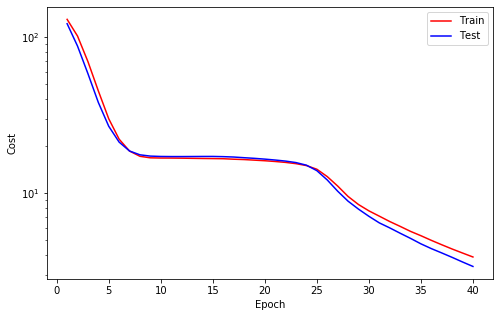



Epoch    41
Train_cost  = 3.6807 | Test_cost  = 3.1710 | 




Epoch    42
Train_cost  = 3.4968 | Test_cost  = 2.9950 | 




Epoch    43
Train_cost  = 3.3311 | Test_cost  = 2.8070 | 




Epoch    44
Train_cost  = 3.1700 | Test_cost  = 2.6437 | 




Epoch    45
Train_cost  = 3.0161 | Test_cost  = 2.4835 | 




Epoch    46
Train_cost  = 2.8719 | Test_cost  = 2.3361 | 




Epoch    47
Train_cost  = 2.7328 | Test_cost  = 2.2026 | 




Epoch    48
Train_cost  = 2.6014 | Test_cost  = 2.0778 | 




Epoch    49
Train_cost  = 2.4752 | Test_cost  = 1.9208 | 




Epoch    50
Train_cost  = 2.3329 | Test_cost  = 1.7817 | 




Epoch    51
Train_cost  = 2.1947 | Test_cost  = 1.6639 | 




Epoch    52
Train_cost  = 2.0698 | Test_cost  = 1.5558 | 




Epoch    53
Train_cost  = 1.9520 | Test_cost  = 1.4489 | 




Epoch    54
Train_cost  = 1.8386 | Test_cost  = 1.3414 | 




Epoch    55
Train_cost  = 1.7228 | Test_cost  = 1.2422 | 




Epoch    56
Train_cost  = 1.6105 | Test_cost  = 1.1513 | 




Epoch    57
Train_cost  = 1.5076 | Test_cost  = 1.0683 | 




Epoch    58
Train_cost  = 1.4133 | Test_cost  = 0.9896 | 




Epoch    59
Train_cost  = 1.3251 | Test_cost  = 0.9151 | 




Epoch    60
Train_cost  = 1.2415 | Test_cost  = 0.8471 | 


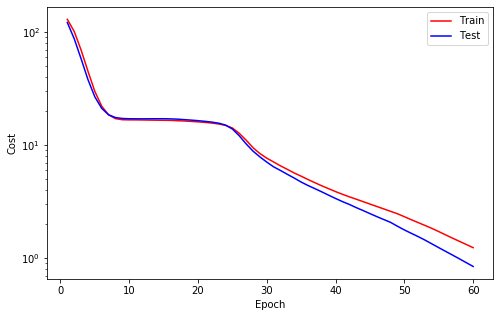



Epoch    61
Train_cost  = 1.1657 | Test_cost  = 0.7864 | 




Epoch    62
Train_cost  = 1.0998 | Test_cost  = 0.7333 | 




Epoch    63
Train_cost  = 1.0439 | Test_cost  = 0.6873 | 




Epoch    64
Train_cost  = 0.9966 | Test_cost  = 0.6476 | 




Epoch    65
Train_cost  = 0.9559 | Test_cost  = 0.6136 | 




Epoch    66
Train_cost  = 0.9209 | Test_cost  = 0.5846 | 




Epoch    67
Train_cost  = 0.8911 | Test_cost  = 0.5595 | 




Epoch    68
Train_cost  = 0.8651 | Test_cost  = 0.5376 | 




Epoch    69
Train_cost  = 0.8418 | Test_cost  = 0.5183 | 




Epoch    70
Train_cost  = 0.8207 | Test_cost  = 0.5011 | 




Epoch    71
Train_cost  = 0.8015 | Test_cost  = 0.4855 | 




Epoch    72
Train_cost  = 0.7838 | Test_cost  = 0.4714 | 




Epoch    73
Train_cost  = 0.7673 | Test_cost  = 0.4585 | 




Epoch    74
Train_cost  = 0.7520 | Test_cost  = 0.4467 | 




Epoch    75
Train_cost  = 0.7375 | Test_cost  = 0.4358 | 




Epoch    76
Train_cost  = 0.7240 | Test_cost  = 0.4256 | 




Epoch    77
Train_cost  = 0.7112 | Test_cost  = 0.4162 | 




Epoch    78
Train_cost  = 0.6992 | Test_cost  = 0.4075 | 




Epoch    79
Train_cost  = 0.6878 | Test_cost  = 0.3993 | 




Epoch    80
Train_cost  = 0.6770 | Test_cost  = 0.3916 | 


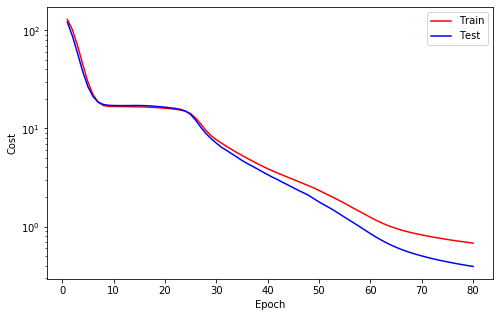



Epoch    81
Train_cost  = 0.6667 | Test_cost  = 0.3845 | 




Epoch    82
Train_cost  = 0.6568 | Test_cost  = 0.3779 | 




Epoch    83
Train_cost  = 0.6474 | Test_cost  = 0.3718 | 




Epoch    84
Train_cost  = 0.6385 | Test_cost  = 0.3661 | 




Epoch    85
Train_cost  = 0.6298 | Test_cost  = 0.3609 | 




Epoch    86
Train_cost  = 0.6215 | Test_cost  = 0.3561 | 




Epoch    87
Train_cost  = 0.6134 | Test_cost  = 0.3517 | 




Epoch    88
Train_cost  = 0.6056 | Test_cost  = 0.3476 | 




Epoch    89
Train_cost  = 0.5980 | Test_cost  = 0.3438 | 




Epoch    90
Train_cost  = 0.5905 | Test_cost  = 0.3403 | 




Epoch    91
Train_cost  = 0.5830 | Test_cost  = 0.3372 | 




Epoch    92
Train_cost  = 0.5757 | Test_cost  = 0.3346 | 




Epoch    93
Train_cost  = 0.5693 | Test_cost  = 0.3332 | 




Epoch    94
Train_cost  = 0.5663 | Test_cost  = 0.3341 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3332




Epoch    95
Train_cost  = 0.5676 | Test_cost  = 0.3409 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3332




Epoch    96
Train_cost  = 0.5700 | Test_cost  = 0.3420 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3332




Epoch    97
Train_cost  = 0.5725 | Test_cost  = 0.3220 | 




Epoch    98
Train_cost  = 0.5611 | Test_cost  = 0.3304 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3220




Epoch    99
Train_cost  = 0.5514 | Test_cost  = 0.3246 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3220




Epoch   100
Train_cost  = 0.5341 | Test_cost  = 0.3179 | 


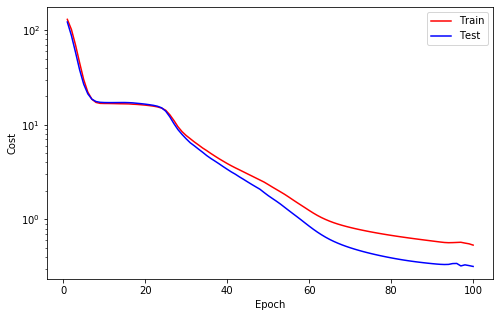



Epoch   101
Train_cost  = 0.5317 | Test_cost  = 0.3199 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3179




Epoch   102
Train_cost  = 0.5344 | Test_cost  = 0.3185 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3179




Epoch   103
Train_cost  = 0.5366 | Test_cost  = 0.3114 | 




Epoch   104
Train_cost  = 0.5312 | Test_cost  = 0.3095 | 




Epoch   105
Train_cost  = 0.5147 | Test_cost  = 0.3092 | 




Epoch   106
Train_cost  = 0.5093 | Test_cost  = 0.3087 | 




Epoch   107
Train_cost  = 0.5126 | Test_cost  = 0.3081 | 




Epoch   108
Train_cost  = 0.5148 | Test_cost  = 0.3122 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3081




Epoch   109
Train_cost  = 0.5165 | Test_cost  = 0.3033 | 




Epoch   110
Train_cost  = 0.5070 | Test_cost  = 0.3026 | 




Epoch   111
Train_cost  = 0.4922 | Test_cost  = 0.3039 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3026




Epoch   112
Train_cost  = 0.4930 | Test_cost  = 0.3024 | 




Epoch   113
Train_cost  = 0.5000 | Test_cost  = 0.3058 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3024




Epoch   114
Train_cost  = 0.5037 | Test_cost  = 0.3029 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3024




Epoch   115
Train_cost  = 0.4914 | Test_cost  = 0.2968 | 




Epoch   116
Train_cost  = 0.4778 | Test_cost  = 0.3004 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2968




Epoch   117
Train_cost  = 0.4822 | Test_cost  = 0.2998 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2968




Epoch   118
Train_cost  = 0.4849 | Test_cost  = 0.3018 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2968




Epoch   119
Train_cost  = 0.4780 | Test_cost  = 0.2946 | 




Epoch   120
Train_cost  = 0.4690 | Test_cost  = 0.2928 | 


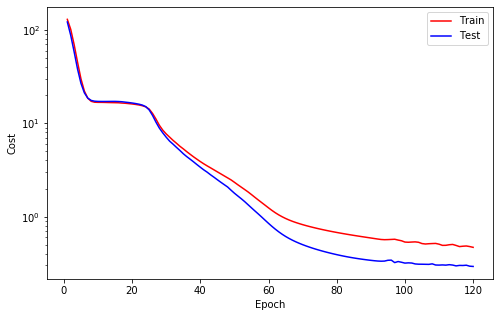



Epoch   121
Train_cost  = 0.4643 | Test_cost  = 0.2977 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2928




Epoch   122
Train_cost  = 0.4672 | Test_cost  = 0.2974 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2928




Epoch   123
Train_cost  = 0.4673 | Test_cost  = 0.2968 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2928




Epoch   124
Train_cost  = 0.4592 | Test_cost  = 0.2892 | 




Epoch   125
Train_cost  = 0.4531 | Test_cost  = 0.2927 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2892




Epoch   126
Train_cost  = 0.4535 | Test_cost  = 0.2955 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2892




Epoch   127
Train_cost  = 0.4586 | Test_cost  = 0.2972 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2892




Epoch   128
Train_cost  = 0.4572 | Test_cost  = 0.2961 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2892




Epoch   129
Train_cost  = 0.4506 | Test_cost  = 0.2883 | 




Epoch   130
Train_cost  = 0.4421 | Test_cost  = 0.2909 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2883




Epoch   131
Train_cost  = 0.4459 | Test_cost  = 0.2926 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2883




Epoch   132
Train_cost  = 0.4495 | Test_cost  = 0.2978 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2883




Epoch   133
Train_cost  = 0.4458 | Test_cost  = 0.2945 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2883




Epoch   134
Train_cost  = 0.4421 | Test_cost  = 0.2880 | 




Epoch   135
Train_cost  = 0.4331 | Test_cost  = 0.2880 | 




Epoch   136
Train_cost  = 0.4367 | Test_cost  = 0.2919 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2880




Epoch   137
Train_cost  = 0.4365 | Test_cost  = 0.2964 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2880




Epoch   138
Train_cost  = 0.4325 | Test_cost  = 0.2919 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2880




Epoch   139
Train_cost  = 0.4299 | Test_cost  = 0.2856 | 




Epoch   140
Train_cost  = 0.4233 | Test_cost  = 0.2853 | 


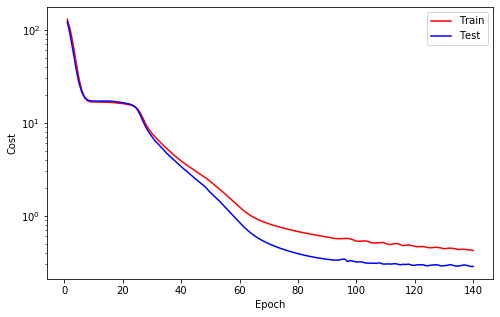



Epoch   141
Train_cost  = 0.4257 | Test_cost  = 0.2922 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2853




Epoch   142
Train_cost  = 0.4246 | Test_cost  = 0.2963 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2853




Epoch   143
Train_cost  = 0.4248 | Test_cost  = 0.2925 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2853




Epoch   144
Train_cost  = 0.4217 | Test_cost  = 0.2824 | 




Epoch   145
Train_cost  = 0.4142 | Test_cost  = 0.2829 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2824




Epoch   146
Train_cost  = 0.4152 | Test_cost  = 0.2905 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2824




Epoch   147
Train_cost  = 0.4165 | Test_cost  = 0.2981 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2824




Epoch   148
Train_cost  = 0.4236 | Test_cost  = 0.2958 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2824




Epoch   149
Train_cost  = 0.4186 | Test_cost  = 0.2812 | 




Epoch   150
Train_cost  = 0.4076 | Test_cost  = 0.2848 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2812




Epoch   151
Train_cost  = 0.4114 | Test_cost  = 0.2897 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2812




Epoch   152
Train_cost  = 0.4128 | Test_cost  = 0.2990 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2812




Epoch   153
Train_cost  = 0.4200 | Test_cost  = 0.2946 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2812




Epoch   154
Train_cost  = 0.4186 | Test_cost  = 0.2837 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2812
==> Execute Early Stopping at epoch: 154 | Best test_cost: 0.2812
==> Best model is saved at model/bilstm


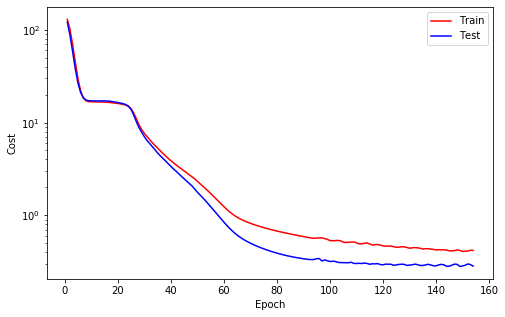

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [17]:
from luwiji.rnn import illustration

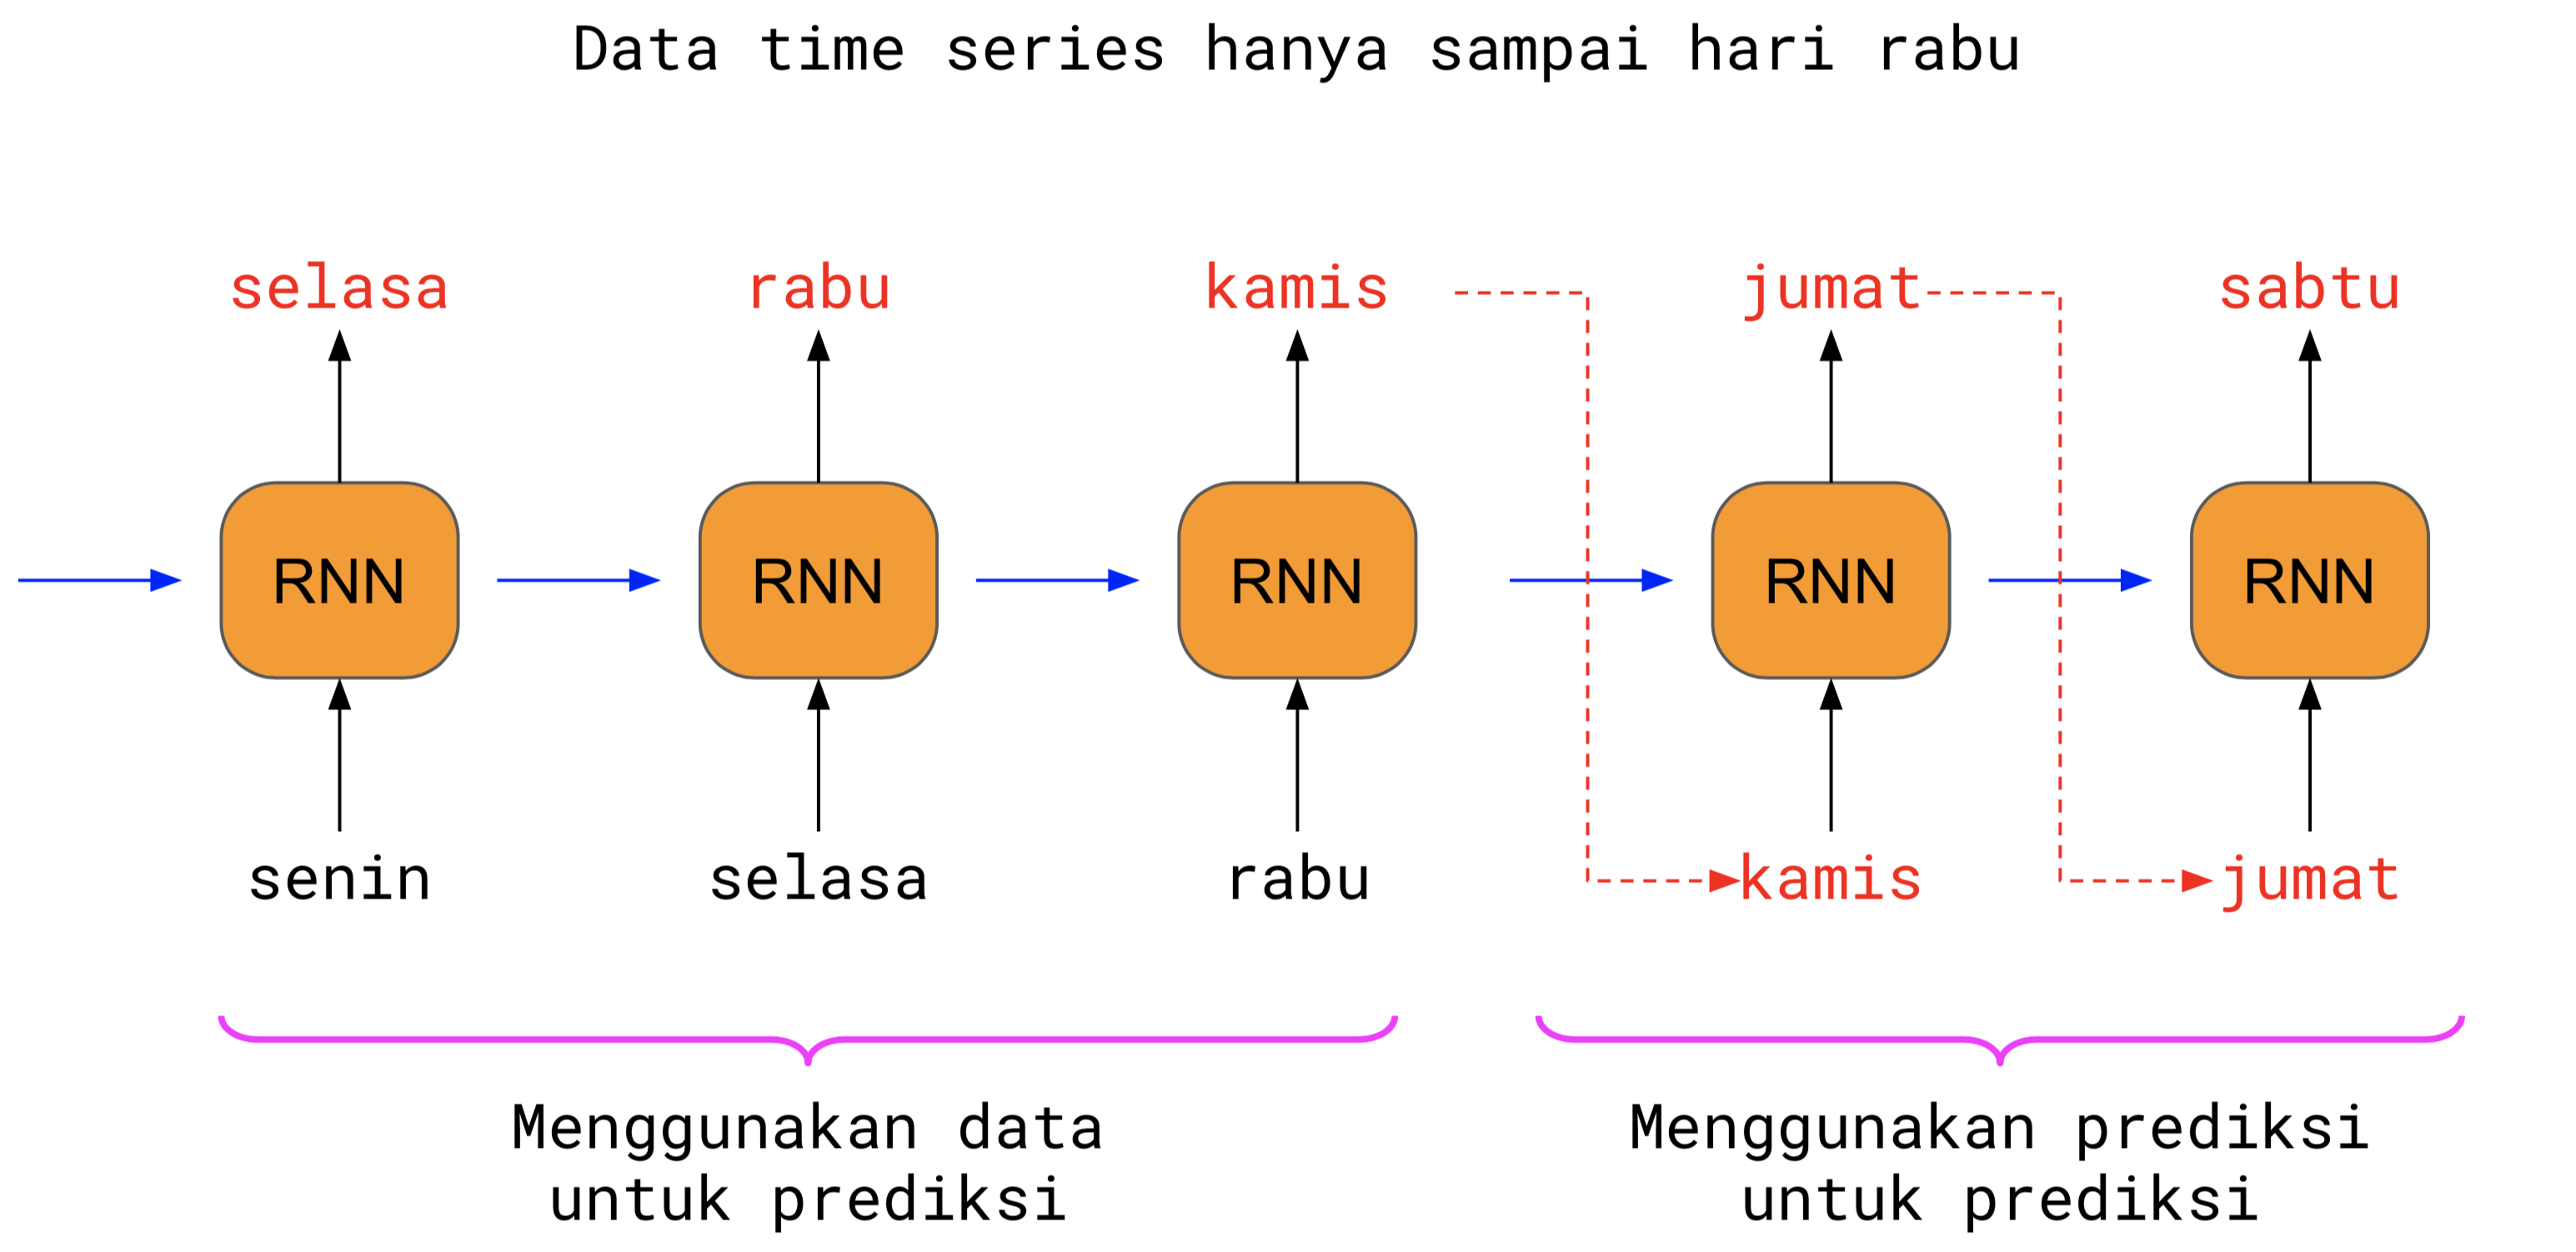

In [18]:
illustration.forecast

In [19]:
from utils import data4pred, pred4pred

In [20]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

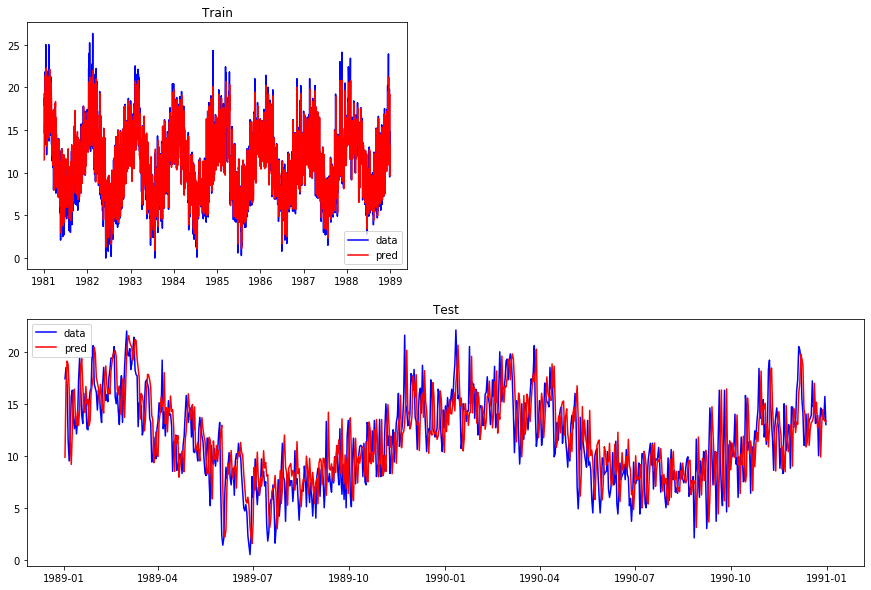

In [21]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(221)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

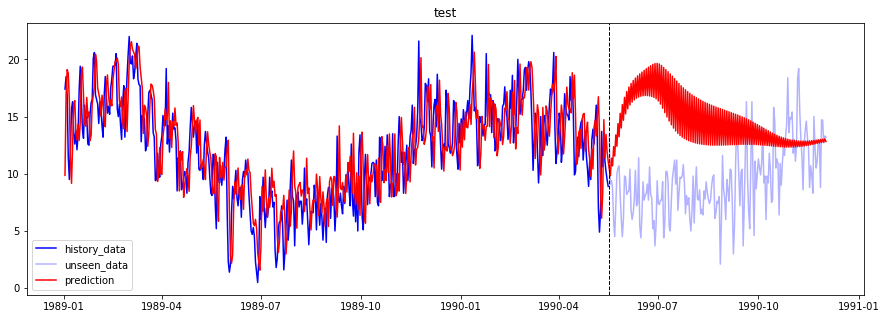

In [22]:
# Pred 4 Pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")